In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read the country reference file
df_countries = pd.read_csv("CT_COUNTRIES.csv", sep=";", header=None, names=["code", "lang", "name"])

country_dict = df_countries.set_index("code")["name"].to_dict()

In [3]:
import io

FILE_PATH     = "EXPORT_DATA_envoi_01_01_2022_30_04_2025.csv"
TARGET_BYTES  = 1 * 1024**3          # ≈1 GB
ENCODING      = "utf-8-sig"          # handles UTF-8 + BOM

def load_gb_chunk(path, chunk_index=0, target_bytes=TARGET_BYTES, **read_kwargs):
    """
    Load the N-th ≈1 GB chunk (0-based) from a large CSV.

    Parameters
    ----------
    path : str
        CSV file path.
    chunk_index : int
        0 for the first gigabyte, 1 for the second, and so on.
    target_bytes : int
        Approximate raw size for each chunk (defaults to 1 GB).

    Returns
    -------
    pandas.DataFrame
        The requested slice as a DataFrame.
    """
    with open(path, "rb") as f:
        header = f.readline()            # capture header once

        # -------- skip over the earlier chunks --------
        for _ in range(chunk_index):
            skipped = 0
            while skipped < target_bytes:
                line = f.readline()
                if not line:             # hit EOF too soon
                    raise ValueError("chunk_index beyond end of file")
                skipped += len(line)

        # -------- collect the requested chunk --------
        buffers      = [header]
        bytes_so_far = len(header)

        while bytes_so_far < target_bytes:
            line = f.readline()
            if not line:                 # EOF
                break
            bytes_so_far += len(line)
            buffers.append(line)

    pseudo_file = io.BytesIO(b"".join(buffers))

    df = pd.read_csv(
        pseudo_file,
        sep=";",
        encoding=ENCODING,
        on_bad_lines="skip",
        dtype=str,
        low_memory=False,
        **read_kwargs,
    )

    # strip any stray BOM from the first column name
    df.columns = df.columns.str.lstrip("\ufeff")
    return df

# -------- examples --------
df = load_gb_chunk(FILE_PATH, chunk_index=5)  # second GB

print("Sixth:", df.shape)


Sixth: (7323078, 7)


In [4]:
first_row_df = df.head(1)   # first_row_df.shape == (1, df.shape[1])
first_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR40117004010086,RB329316512SG,Expédier envoi à adresse nationale (Srt),2024-02-04 09:36:00.273,ANNABA EL MARSA,2,ANNABA-EDOUGH


In [5]:
last_row_df  = df.tail(1)   # last_row_df.shape  == (1, df.shape[1])
last_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
7323077,VNSGNADZALGDAUN50002001110011,RR729864191VN,Vaine tentative de livraison d'envoi (Ent),2025-04-20 06:47:07.467,BEB EL OUED,36,NaN


In [6]:
distinct_values_count = df.nunique()

distinct_values_count = distinct_values_count.sort_values(ascending=True)

print(distinct_values_count)

EVENT_TYPE_NM                     22
EVENT_TYPE_CD                     22
next_établissement_postal       3437
établissement_postal            3581
RECPTCL_FID                    55181
MAILITM_FID                  1313659
date                         7083731
dtype: int64


In [7]:
print("the number of not missing bags is", 10103605 - 6909038)

the number of not missing bags is 3194567


In [8]:
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

next_établissement_postal    4921215
dtype: int64


In [9]:

# Assuming 'df' is your DataFrame!

# Identify the rows with missing values
missing_rows = df[df.isnull().any(axis=1)]

# Print the total number of rows that have missing values
print("Total rows with missing values:", missing_rows.shape[0])




Total rows with missing values: 4921215


In [10]:
# Analyze the missing patterns across rows:
# Create a binary pattern for each row where 1 indicates a missing value and 0 indicates non-missing.
missing_pattern = missing_rows.isnull().astype(int)
# Convert each pattern to a tuple to use as a key for groupby
missing_pattern_tuples = missing_pattern.apply(tuple, axis=1)
# Group by the missing pattern and count the number of rows for each pattern
pattern_summary = missing_rows.groupby(missing_pattern_tuples).size().sort_values(ascending=False)

print("\nSummary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):")
print(pattern_summary)




Summary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):
(0, 0, 0, 0, 0, 0, 1)    4921215
dtype: int64


In [11]:
unique_vals = df['next_établissement_postal'].dropna().unique()
for v in unique_vals:
    print(repr(v))

'ANNABA-EDOUGH'
'ANNABA EL MARSA'
'CDD TEBESSA'
'CDD AIN DEFLA'
'AHMED DRAIA'
'HDJAR EDISS'
'BIRTOUTA BP'
'ALGER GARE'
'TISSEMSILT-RP'
'CDD TISSEMSILT'
'M DAOUROUCHE'
'ORAN COLIS POSTAUX'
'HAI-EL-YASMINE'
'DAR EL BEIDA'
'CDD KOUBA'
'HAI EL BADR'
'SECTION PAQUETS CPX ALGER'
'CDD BATNA'
'OULED DJELLAL'
'CHETOUANE-1ER-NOV'
'BABOR'
'CDD BLIDA'
'BLIDA BOUNAAMA DJILLALI'
'CTR CHLEF'
'DAHMOUNI'
'ARZEW'
'MAGHNIA'
'TISSEMSILT-NAANAA-AHMED'
'ORAN-RP'
'MASCARA-EMIR-ABDELKADER'
'CDD SETIF'
'KHENCHELA ENNASR'
'SIDI-ALI-BOUGHAZI-MED'
'CONSTANTINE COLIS POSTAUX'
'CDD BBA'
'BIR KASDALI'
'CDD KHENCHELA'
'BORDJ-BOUNAAMA'
'OUM-EL-BOUAGHI-RP'
'ABOU-EL-HASSAN'
'CDD SKIKDA'
'BORDJ EL KIFFAN FAIZI'
'CDD CONSTANTINE'
'TISSEMSILT-EL-MERDJA'
'CDD SIDI BELABES'
'SKIKDA 8 MAI 1945'
'OUED-GHIR'
'CDD SAIDA'
'CDD MILA'
'CDD-ALGER-MALIKA-GAID'
'CDD MOSTAGHANEM'
'CDD AFLOU'
'ARBID-ALI'
'BEN AKNOUN'
'AIN OULMENE'
'CITE 5 JUILLET'
'SIDI OKBA'
'CDD MECHERIA'
'AIN-BEN-KHELIL'
'CDD OUARGLA'
'ORAN-HAI-BOUAMAMA'
'CDD LAGHOUA

EVENT_TYPE_NM
Recevoir envoi au bureau de livraison (Ent)                    1765958
Expédier envoi à adresse nationale (Ent)                       1277011
Expédier envoi à adresse nationale (Srt)                       1104215
Vaine tentative de livraison d'envoi (Ent)                      886175
Recevoir envoi au bureau d'échange (Ent)                        860117
Livraison d'envoi (Ent)                                         783849
Transmettre envoi à l'agent de livraison (Ent)                  471772
Enregistrer détails d'envoi au bureau d'échange (Srt)           120773
Expédier envoi à la douane (Ent)                                 20507
Insérer envoi dans sac (Srt)                                     12360
Recevoir envoi au bureau d'échange (Srt)                          9513
Renvoyer envoi de la douane (Ent)                                 7927
Renvoyer envoi de la douane (Srt)                                 1278
Recevoir envoi au lieu (Ent)                                   

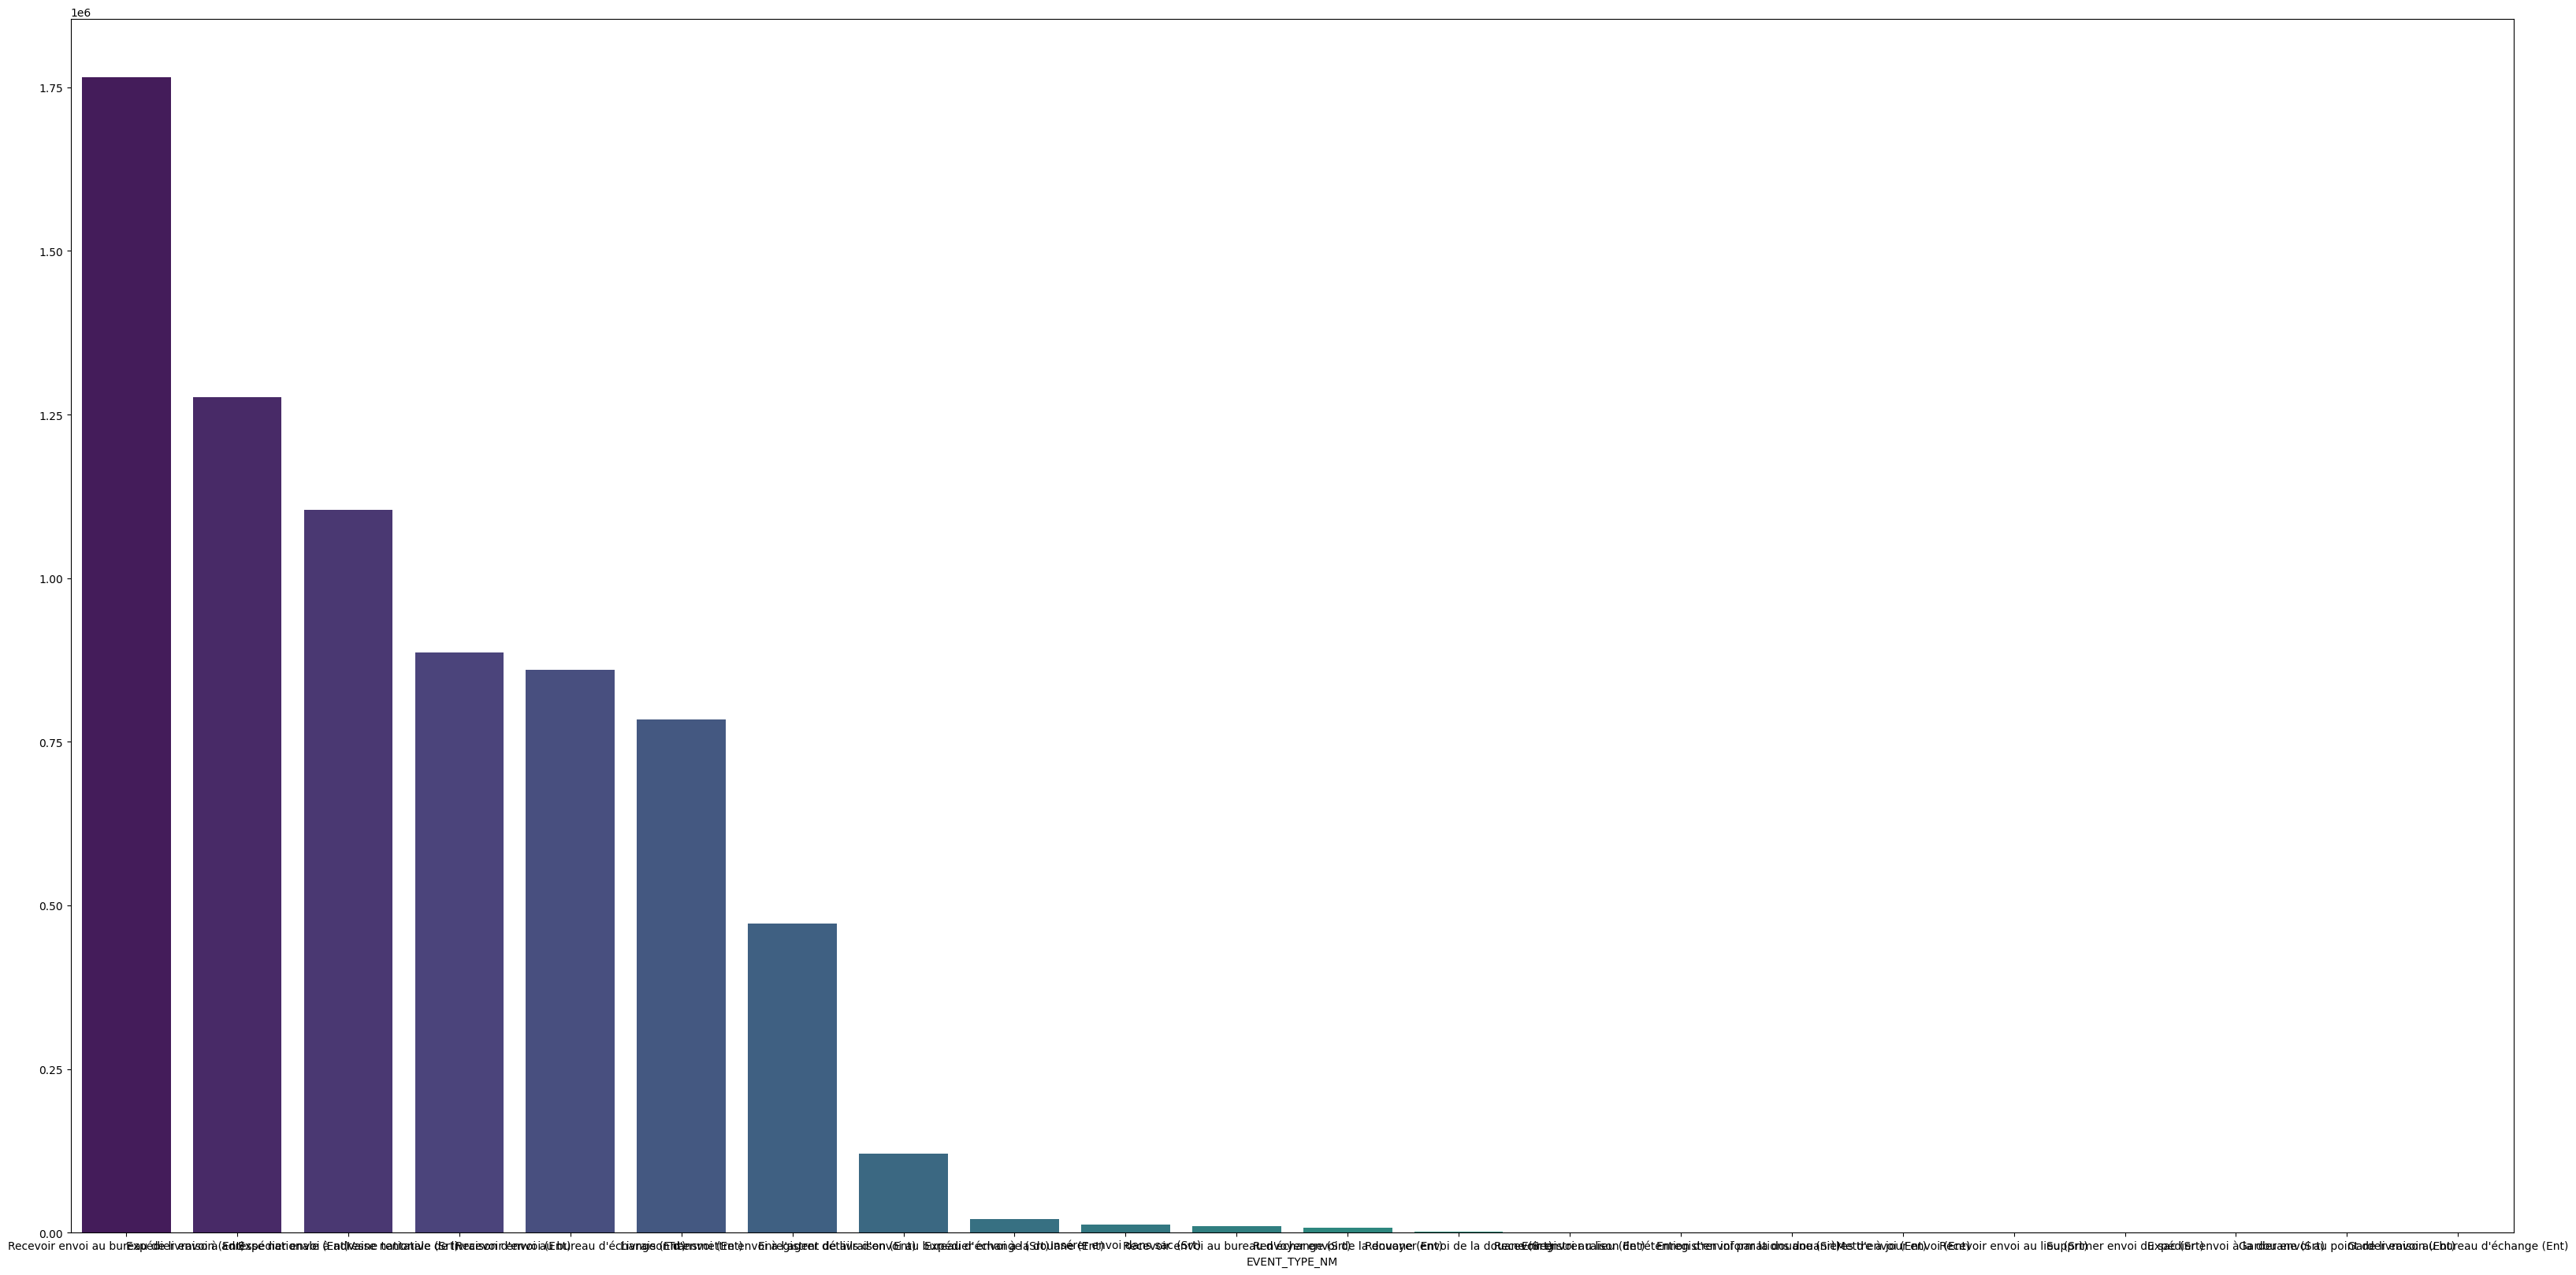

In [12]:

# Count the occurrences of each protocol
event_type = df['EVENT_TYPE_NM'].value_counts()

print(event_type)

# Visualize the counts of each protocol
plt.figure(figsize=(40, 20))
sns.barplot(x=event_type.index, y=event_type.values, palette='viridis')
plt.show()

In [13]:

# Count the occurrences of each protocol
proto_counts = df['établissement_postal'].value_counts()

print(proto_counts)


établissement_postal
ALGER GARE                   1134005
ALGER COLIS POSTAUX           945614
CONSTANTINE COLIS POSTAUX     329065
ANNABA EL MARSA               201519
CTR CHLEF                     161382
                              ...   
AIN-SKHOUNA                        1
1er NOVEMBRE 54                    1
SIDI-ADDA                          1
EL-AMRIA-TAIBI-KOUIDER             1
Agence EMS SILA                    1
Name: count, Length: 3581, dtype: int64


In [14]:
# Count the occurrences of each protocol
proto_counts = df['next_établissement_postal'].value_counts()

print(proto_counts)



next_établissement_postal
ALGER GARE                                298370
ORAN COLIS POSTAUX                        124577
CONSTANTINE COLIS POSTAUX                 123777
ANNABA EL MARSA                            97921
SECTION PAQUETS CPX ALGER                  81859
                                           ...  
ISSR TIAKICHE SAID                             1
TELAGH-MOKDAD-MED                              1
CENTRE DE PERSONNALISATION DES CARTES          1
KOLEA ICHARA                                   1
RESIDENCE UNIVERSITAIRE AINOUCHE CHAMA         1
Name: count, Length: 3437, dtype: int64


In [15]:
# Rows whose RECPTCL_FID is not NaN
rec_present = df[df["RECPTCL_FID"].notna()]

# Show the first five
rec_present.head()


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR40117004010086,RB329316512SG,Expédier envoi à adresse nationale (Srt),2024-02-04 09:36:00.273,ANNABA EL MARSA,2,ANNABA-EDOUGH
1,SGSINBDZALGDAUR40117004010086,RB329316512SG,Vaine tentative de livraison d'envoi (Ent),2024-02-05 09:45:40.500,ANNABA-EDOUGH,36,NaN
2,SGSINBDZALGDAUR40117004010086,RB329317138SG,Expédier envoi à adresse nationale (Ent),2024-02-01 08:43:14.450,ALGER COLIS POSTAUX,35,ANNABA EL MARSA
3,SGSINBDZALGDAUR40117004010086,RB329317138SG,Expédier envoi à adresse nationale (Srt),2024-02-04 09:00:20.907,ANNABA EL MARSA,2,CDD TEBESSA
4,SGSINBDZALGDAUR40117004010086,RB329317138SG,Livraison d'envoi (Ent),2024-02-15 09:10:12.293,CDD TEBESSA,37,NaN


In [16]:
# 1️⃣  Make sure the column is treated as text (protects against NaNs)
fid = df["MAILITM_FID"].astype("string")

# 2️⃣  Boolean mask: True if both trailing characters are letters (A-Z / a-z)
two_letter_suffix = fid.str[-2:].str.isalpha()

# --- Quick sanity check
print(two_letter_suffix.value_counts(dropna=False))
# True  : rows where the code ends in letters (e.g. "ES")
# False : rows where it ends in digits or something else
# <NA>  : rows where MAILITM_FID itself is missing


MAILITM_FID
True    7323078
Name: count, dtype: Int64


In [18]:
bad_suffix = df[~two_letter_suffix & fid.notna()]

print(f"Bad rows: {len(bad_suffix):,}")
bad_suffix.head()   # peek at the first few offenders



Bad rows: 0


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal


In [17]:
# Build the “good suffix” mask once
suffix_ok = (
    df["MAILITM_FID"]
      .astype("string")
      .str[-2:]
      .str.isalpha()
      .fillna(False)          # treat missing IDs as bad
)

df = df[suffix_ok]

# Quick confirmation
print(f"Rows left: {len(df):,}")
df.head()


Rows left: 7,323,078


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR40117004010086,RB329316512SG,Expédier envoi à adresse nationale (Srt),2024-02-04 09:36:00.273,ANNABA EL MARSA,2,ANNABA-EDOUGH
1,SGSINBDZALGDAUR40117004010086,RB329316512SG,Vaine tentative de livraison d'envoi (Ent),2024-02-05 09:45:40.500,ANNABA-EDOUGH,36,NaN
2,SGSINBDZALGDAUR40117004010086,RB329317138SG,Expédier envoi à adresse nationale (Ent),2024-02-01 08:43:14.450,ALGER COLIS POSTAUX,35,ANNABA EL MARSA
3,SGSINBDZALGDAUR40117004010086,RB329317138SG,Expédier envoi à adresse nationale (Srt),2024-02-04 09:00:20.907,ANNABA EL MARSA,2,CDD TEBESSA
4,SGSINBDZALGDAUR40117004010086,RB329317138SG,Livraison d'envoi (Ent),2024-02-15 09:10:12.293,CDD TEBESSA,37,NaN


In [18]:
df['id'] = df["MAILITM_FID"].str[-2:]
df.head()

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id
0,SGSINBDZALGDAUR40117004010086,RB329316512SG,Expédier envoi à adresse nationale (Srt),2024-02-04 09:36:00.273,ANNABA EL MARSA,2,ANNABA-EDOUGH,SG
1,SGSINBDZALGDAUR40117004010086,RB329316512SG,Vaine tentative de livraison d'envoi (Ent),2024-02-05 09:45:40.500,ANNABA-EDOUGH,36,NaN,SG
2,SGSINBDZALGDAUR40117004010086,RB329317138SG,Expédier envoi à adresse nationale (Ent),2024-02-01 08:43:14.450,ALGER COLIS POSTAUX,35,ANNABA EL MARSA,SG
3,SGSINBDZALGDAUR40117004010086,RB329317138SG,Expédier envoi à adresse nationale (Srt),2024-02-04 09:00:20.907,ANNABA EL MARSA,2,CDD TEBESSA,SG
4,SGSINBDZALGDAUR40117004010086,RB329317138SG,Livraison d'envoi (Ent),2024-02-15 09:10:12.293,CDD TEBESSA,37,NaN,SG


In [19]:

# Count the occurrences of each protocol
proto_counts = df['id'].value_counts()

print(proto_counts)

s = proto_counts


id
SG    6967462
US     117506
TR      92464
SE      71111
TN      44013
       ...   
BF          6
OM          4
ME          4
TJ          2
GQ          1
Name: count, Length: 68, dtype: int64


In [20]:
# Map the Series index using the country_dict
s.index = s.index.map(lambda code: country_dict.get(code, code))  # Keep unmapped codes as-is
print(s)

id
SINGAPOUR             6967462
ÉTATS-UNIS             117506
TURQUIE                 92464
SUÈDE                   71111
TUNISIE                 44013
                       ...   
BURKINA FASO                6
OMAN                        4
ME                          4
TADJIKISTAN                 2
GUINÉE ÉQUATORIALE          1
Name: count, Length: 68, dtype: int64


In [21]:
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())

Min date: 2018-11-15 10:24:59.583
Max date: 2025-05-21 15:54:58.333


In [22]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S.%f")
# Sort by ID and date
df = df.sort_values(by=["MAILITM_FID", "date"])

# Calculate time to next step
df["duration_to_next_step"] = df.groupby("MAILITM_FID")["date"].shift(-1) - df["date"]

# Calculate total duration per ID
first_date = df.groupby("MAILITM_FID")["date"].transform("first")
last_date = df.groupby("MAILITM_FID")["date"].transform("last")
df["total_duration"] = last_date - first_date

# Preview the updated dataset
df[["MAILITM_FID", "date", "EVENT_TYPE_NM", "duration_to_next_step", "total_duration"]].head(10)


,MAILITM_FID,date,EVENT_TYPE_NM,duration_to_next_step,total_duration
7178090,CA000020800LY,2022-02-22 09:50:25.897,Recevoir envoi au bureau d'échange (Ent),0 days 00:01:37.313000,5 days 23:39:58.013000
7178087,CA000020800LY,2022-02-22 09:52:03.210,Expédier envoi à adresse nationale (Ent),0 days 00:42:49.187000,5 days 23:39:58.013000
7178088,CA000020800LY,2022-02-22 10:34:52.397,Expédier envoi à adresse nationale (Ent),1 days 23:56:45.563000,5 days 23:39:58.013000
1691370,CA000020800LY,2022-02-24 10:31:37.960,Expédier envoi à adresse nationale (Srt),1 days 23:49:42,5 days 23:39:58.013000
1691372,CA000020800LY,2022-02-26 10:21:19.960,Recevoir envoi au bureau de livraison (Ent),0 days 00:02:44.013000,5 days 23:39:58.013000
1691371,CA000020800LY,2022-02-26 10:24:03.973,Expédier envoi à adresse nationale (Srt),0 days 23:16:11.640000,5 days 23:39:58.013000
1691373,CA000020800LY,2022-02-27 09:40:15.613,Recevoir envoi au bureau de livraison (Ent),0 days 00:00:34.660000,5 days 23:39:58.013000
7178091,CA000020800LY,2022-02-27 09:40:50.273,Transmettre envoi à l'agent de livraison (Ent),0 days 23:49:33.637000,5 days 23:39:58.013000
7178089,CA000020800LY,2022-02-28 09:30:23.910,Livraison d'envoi (Ent),NaT,5 days 23:39:58.013000
7274956,CA000086085US,2024-11-30 08:24:22.110,Recevoir envoi au bureau d'échange (Ent),0 days 02:49:00.743000,10 days 23:44:14.180000


In [23]:
df.to_csv("df_with_durations_06.csv", index=False, encoding='utf-8-sig')

In [ ]:
print("no zero duration", 10103602 - 1712240)

no zervo duration 8391362


In [24]:
# Filter rows where total_duration is NOT zero
zero_duration_df = df[df["total_duration"] == pd.Timedelta(0)]

# Display the first few rows as a check
zero_duration_df.shape


(37004, 10)

In [25]:

# Count the occurrences of each protocol
countries = zero_duration_df['id'].value_counts()

print(countries)


id
SG    36956
SE       14
US       10
TH        7
TR        4
UA        2
AZ        2
TN        2
BE        2
PK        1
FR        1
AL        1
GQ        1
UZ        1
Name: count, dtype: int64


In [26]:
# Map the Series index using the country_dict
countries.index = countries.index.map(lambda code: country_dict.get(code, code))  
print(countries)

id
SINGAPOUR             36956
SUÈDE                    14
ÉTATS-UNIS               10
THAÏLANDE                 7
TURQUIE                   4
UKRAINE                   2
AZERBAÏDJAN               2
TUNISIE                   2
BELGIQUE                  2
PAKISTAN                  1
FRANCE                    1
ALBANIE                   1
GUINÉE ÉQUATORIALE        1
OUZBÉKISTAN               1
Name: count, dtype: int64


In [27]:
# Step 1: Count how many times each ID appears
id_counts = zero_duration_df["MAILITM_FID"].value_counts()

# Step 2: Count how many IDs have a specific count
count_of_counts = id_counts.value_counts().sort_index()

print(count_of_counts)


count
1    37004
Name: count, dtype: int64


In [28]:
ids_with_0 = id_counts[id_counts == 1].index
df_with_0 = df[df["MAILITM_FID"].isin(ids_with_0)]
df_with_0.head(20)

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id,duration_to_next_step,total_duration
1690828,TRISTBDZALGBACN50040001000152,CC003278442PK,Recevoir envoi au bureau d'échange (Ent),2025-03-08 09:14:15.057,ALGER COLIS POSTAUX,30,NaN,PK,NaT,0 days
7145937,THBKKCDZALGBACN42030003100194,CP068461875TH,Recevoir envoi au bureau d'échange (Ent),2024-06-19 10:52:01.590,ALGER COLIS POSTAUX,30,NaN,TH,NaT,0 days
7145934,THBKKCDZALGBACN42030001000195,CP068461884TH,Recevoir envoi au bureau d'échange (Ent),2024-06-19 10:52:20.767,ALGER COLIS POSTAUX,30,NaN,TH,NaT,0 days
1656662,THBKKCDZALGBACN42048002100199,CP068462845TH,Recevoir envoi au bureau d'échange (Ent),2024-10-14 08:51:44.757,ALGER COLIS POSTAUX,30,NaN,TH,NaT,0 days
1656540,THBKKCDZALGBACN42033002000199,CP070826787TH,Recevoir envoi au bureau d'échange (Ent),2024-06-19 09:08:26.517,ALGER COLIS POSTAUX,30,NaN,TH,NaT,0 days
7145953,THBKKCDZALGBACN42033001000198,CP070826795TH,Recevoir envoi au bureau d'échange (Ent),2024-06-19 10:53:21.673,ALGER COLIS POSTAUX,30,NaN,TH,NaT,0 days
7145954,THBKKCDZALGBACN42033003100200,CP070826827TH,Recevoir envoi au bureau d'échange (Ent),2024-06-19 10:54:05.453,ALGER COLIS POSTAUX,30,NaN,TH,NaT,0 days
7146019,THBKKCDZALGBACN42048001000198,CP070826977TH,Recevoir envoi au bureau d'échange (Ent),2024-10-14 08:53:46.060,ALGER COLIS POSTAUX,30,NaN,TH,NaT,0 days
1839135,USORDADZALGBACN30145004900010,CY360411315US,Recevoir envoi au bureau d'échange (Ent),2023-11-25 09:01:29.807,ALGER COLIS POSTAUX,30,NaN,US,NaT,0 days
1675599,TNTUNCDZALGDAUN30023001110066,LJ001588906FR,Recevoir envoi au bureau d'échange (Ent),2023-03-27 08:33:37.930,ALGER GARE,30,NaN,FR,NaT,0 days


In [29]:

# Count the occurrences of each protocol
event_type = df_with_0['EVENT_TYPE_NM'].value_counts()

print(event_type)



EVENT_TYPE_NM
Expédier envoi à adresse nationale (Ent)                       7500
Recevoir envoi au bureau d'échange (Ent)                       7371
Recevoir envoi au bureau de livraison (Ent)                    6888
Expédier envoi à adresse nationale (Srt)                       4107
Livraison d'envoi (Ent)                                        4031
Vaine tentative de livraison d'envoi (Ent)                     2931
Expédier envoi à la douane (Ent)                               1936
Transmettre envoi à l'agent de livraison (Ent)                 1564
Enregistrer détails d'envoi au bureau d'échange (Srt)           203
Insérer envoi dans sac (Srt)                                    190
Recevoir envoi au bureau d'échange (Srt)                        139
Renvoyer envoi de la douane (Ent)                               123
Enregistrer raison de rétention d'envoi par la douane (Srt)      10
Enregistrer informations douanières d'envoi (Ent)                 8
Mettre à jour envoi (Ent)         